In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
df = pd.read_csv('Dataset_A_loan.csv')
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   42750 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [5]:
print(df.isnull().sum())

person_age                           0
person_gender                        0
person_education                     0
person_income                     2250
person_emp_exp                       0
person_home_ownership                0
loan_amnt                            0
loan_intent                          0
loan_int_rate                        0
loan_percent_income                  0
cb_person_cred_hist_length           0
credit_score                         0
previous_loan_defaults_on_file       0
loan_status                          0
dtype: int64


In [6]:
df.shape

(45000, 14)

In [7]:
df['loan_status'].value_counts()

loan_status
0    35000
1    10000
Name: count, dtype: int64

In [8]:
for col in df.columns:
    print(f"\nValue counts untuk kolom: {col}")
    print(df[col].value_counts(dropna=False))  



Value counts untuk kolom: person_age
person_age
23.0     5254
24.0     5138
25.0     4507
22.0     4236
26.0     3659
27.0     3095
28.0     2728
29.0     2455
30.0     2021
31.0     1645
32.0     1403
21.0     1289
33.0     1240
34.0      980
35.0      847
36.0      740
37.0      666
38.0      503
39.0      389
40.0      349
41.0      303
42.0      247
43.0      215
44.0      177
45.0      135
46.0      114
47.0      112
48.0       93
49.0       59
50.0       56
51.0       46
52.0       42
53.0       35
54.0       24
55.0       24
58.0       20
56.0       20
57.0       17
20.0       17
60.0       16
61.0       12
66.0       11
65.0       10
70.0        7
64.0        7
62.0        7
59.0        6
69.0        5
144.0       3
73.0        3
63.0        3
123.0       2
78.0        1
94.0        1
80.0        1
84.0        1
76.0        1
67.0        1
116.0       1
109.0       1
Name: count, dtype: int64

Value counts untuk kolom: person_gender
person_gender
male       24799
female     20

Ada beberapa kendala dalam dataset ini, antara lain:
- 2250 nilai pada kolom person_income null
- person_age bertipe float, yang seharusnya int
- cb_person_cred_hist_length sesuai dengan deskripsi variabel, kolom ini adalah durasi credit dalam TAHUN. Sehingga seharusnya bertipe int bukan float.
- ketidakkonsistensian nilai di kolom person_gender.

## Preprocessing

In [9]:
input_df=df.drop('loan_status',axis=1)
output_df=df['loan_status']

x_train, x_test, y_train, y_test = train_test_split(input_df, output_df, test_size = 0.2, random_state = 42)

In [10]:
x_train[x_train.duplicated()]

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file


In [11]:
x_test[x_test.duplicated()]

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file


Sesuai dengan deskripsi, 'loan_status' adalah variabel target untuk kasus ini. Lalu proporsi train : testing adalah 80 : 20.
Dilakukan juga pengecekan terhadap nilai duplikat, ternyata baik data testing dan training, keduanya tidak memiliki nilai duplikat.

In [12]:
x_train['person_age'] = x_train['person_age'].astype('int64')
x_test['person_age'] = x_test['person_age'].astype('int64')

x_train['cb_person_cred_hist_length'] = x_train['cb_person_cred_hist_length'].astype('int64')
x_test['cb_person_cred_hist_length'] = x_test['cb_person_cred_hist_length'].astype('int64')


In [13]:
x_train['person_gender'] = x_train['person_gender'].replace({
    'fe male': 'female',
    'Male': 'male'
})

x_test['person_gender'] = x_test['person_gender'].replace({
    'fe male': 'female',
    'Male': 'male'
})

Masuk untuk mengatasi masalah dataset di awal :
- Mengubah tipe data 'person_age' dan 'cb_person_cred_hist_length' yang awalnya float, menjadi int.
- menggantikan ketidakonsistensian data di kolom person_gender (ada spasi dan huruf kapital).


In [14]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36000 entries, 25180 to 15795
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      36000 non-null  int64  
 1   person_gender                   36000 non-null  object 
 2   person_education                36000 non-null  object 
 3   person_income                   34231 non-null  float64
 4   person_emp_exp                  36000 non-null  int64  
 5   person_home_ownership           36000 non-null  object 
 6   loan_amnt                       36000 non-null  float64
 7   loan_intent                     36000 non-null  object 
 8   loan_int_rate                   36000 non-null  float64
 9   loan_percent_income             36000 non-null  float64
 10  cb_person_cred_hist_length      36000 non-null  int64  
 11  credit_score                    36000 non-null  int64  
 12  previous_loan_defaults_on_file  3

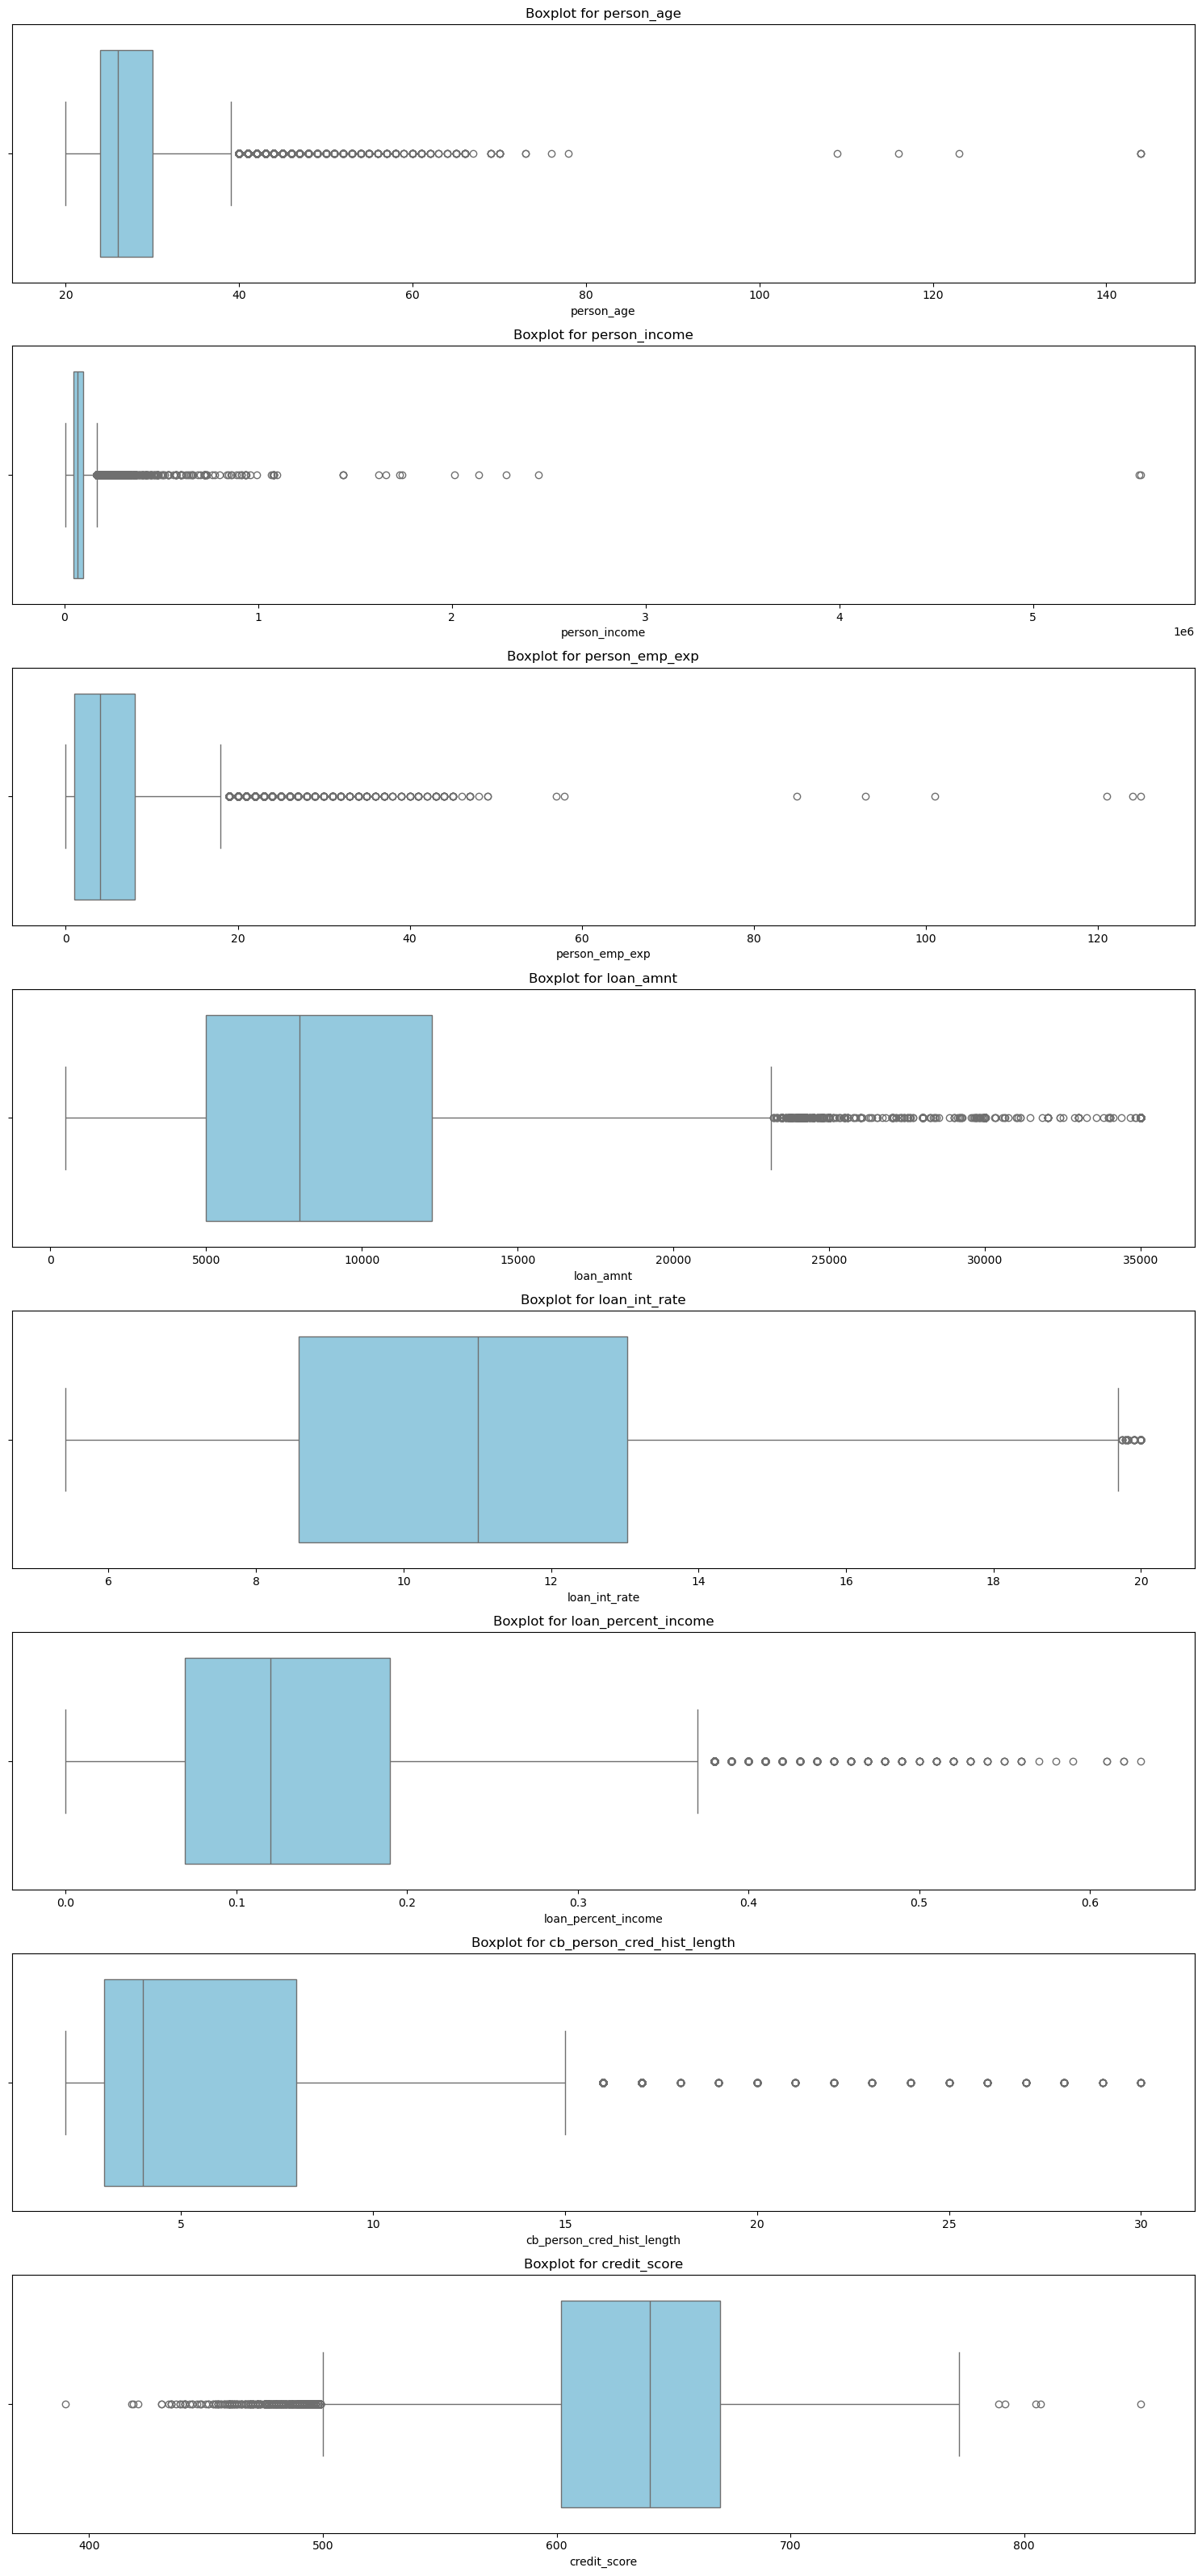

In [15]:
numeric_cols = x_train.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, len(numeric_cols) * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(data=x_train, x=col, color='skyblue')
    plt.title(f'Boxplot for {col}')
    plt.tight_layout()

plt.show()


Karena kasus kali ini berkaitan dengan pinjaman uang, umur menjadi indikator yang cukup berpengaruh. Ketika dilakukan pengecekan, ketika umur seseorang berada di atas umur 70, maka status peminjamannya (loan_status) akan ditolak. Maka ketika menemui data dimana umur di atas 70, data tersebut kurang terpakai untuk melakukan prediksi ini. dan kalau dilihat juga, jumlah data untuk umur di atas 70 itu sedikit jadi tidak memberi kontribusi yang signifikan.

In [16]:
df[df['person_age'] > 70]

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
81,144.0,male,Bachelor,300616.0,125,RENT,4800.0,VENTURE,13.57,0.02,3.0,789,No,0
183,144.0,male,Associate,241424.0,121,MORTGAGE,6000.0,EDUCATION,11.86,0.02,2.0,807,No,0
575,123.0,female,High School,97140.0,101,RENT,20400.0,EDUCATION,10.25,0.21,3.0,805,Yes,0
747,123.0,male,Bachelor,94723.0,100,RENT,20000.0,VENTURE,11.01,0.21,4.0,714,Yes,0
32297,144.0,female,Associate,NaN,124,MORTGAGE,5000.0,PERSONAL,12.73,0.00,25.0,850,No,0
32355,78.0,male,Associate,58463.0,57,RENT,3000.0,MEDICAL,7.51,0.05,25.0,754,No,0
32381,73.0,female,Bachelor,51415.0,47,MORTGAGE,5000.0,PERSONAL,7.49,0.10,28.0,706,No,0
32416,94.0,male,High School,29738.0,76,RENT,6500.0,MEDICAL,11.01,0.22,27.0,773,No,0
32422,80.0,male,High School,77894.0,62,RENT,6800.0,MEDICAL,11.71,0.09,25.0,673,No,0
32432,73.0,male,Bachelor,90678.0,47,RENT,7800.0,MEDICAL,11.01,0.09,24.0,696,Yes,0


In [35]:
to_drop = x_train[x_train['person_age'] > 70].index

x_train = x_train.drop(to_drop)
y_train = y_train.drop(to_drop)

x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

Lalu masuk ke income, yang juga berkaitan erat dengan pinjaman. Disini saya ambil batas bawah dan nilai tengah dari income setelah saya drop row dengan usia di atas 70.
Dengan melihat ini, saya ingin mengetahui apakah dengan pendapatan di bawah batas bawah atau median itu pengajuan pinjamannya akan ditolak. Ternyata jika dilihat, masih ada pinjaman yang disetujui meskipun pendapatannya di bawah nilai tersebut.

In [18]:
income_25th_percentile = x_train['person_income'].quantile(0.25)
income_50th_percentile = x_train['person_income'].median()

print(f"Batas Bawah: {income_25th_percentile}")
print(f"Median: {income_50th_percentile}")


Batas Bawah: 47321.5
Median: 67103.5


In [19]:
df[df['person_income'] < 47321.5]

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1
11,21.0,female,Associate,13113.0,0,OWN,4500.0,HOMEIMPROVEMENT,8.63,0.34,2.0,651,No,1
19,24.0,female,Master,14283.0,1,MORTGAGE,1750.0,EDUCATION,10.99,0.12,2.0,679,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44991,24.0,male,High School,37786.0,0,MORTGAGE,13500.0,EDUCATION,13.43,0.36,4.0,612,No,1
44992,23.0,female,Bachelor,40925.0,0,RENT,9000.0,PERSONAL,11.01,0.22,4.0,487,No,1
44993,27.0,female,High School,35512.0,4,RENT,5000.0,PERSONAL,15.83,0.14,5.0,505,No,1
44994,24.0,female,Associate,31924.0,2,RENT,12229.0,MEDICAL,10.70,0.38,4.0,678,No,1


In [20]:
df[df['person_income'] < 67103.5]

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1
11,21.0,female,Associate,13113.0,0,OWN,4500.0,HOMEIMPROVEMENT,8.63,0.34,2.0,651,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


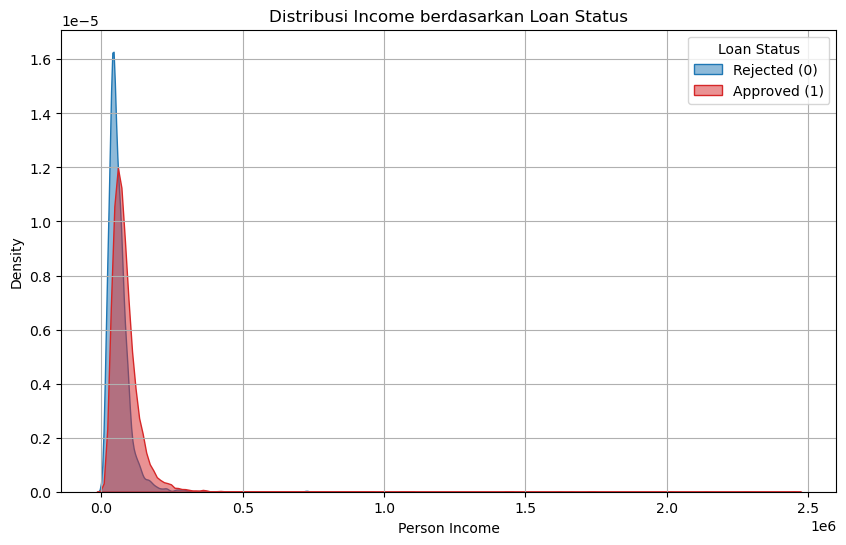

In [21]:
custom_palette = {1: '#1f77b4', 0: '#d62728'}

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=x_train,
    x='person_income',
    hue=y_train,
    fill=True,
    common_norm=False,
    alpha=0.5,
    palette=custom_palette
)
plt.title('Distribusi Income berdasarkan Loan Status')
plt.xlabel('Person Income')
plt.ylabel('Density')
plt.legend(title='Loan Status', labels=['Rejected (0)', 'Approved (1)'])
plt.grid(True)
plt.show()


Lalu imputasi untuk kolom person_income. Pendapatan seseorang biasanya dipengaruhi oleh pendidikannya juga, makanya saya mengimputasi nilai person_income dengan nilai gabungan dari pendidikan dan pendapatannya.
Pemilihan median dikarenakan median lebih representatif untuk data yang skew. Pada grafik di atas, terlihat untuk person_income itu right skewed, dimana distribusi condong ke kiri dengan ekor panjang ke kanan. Artinya kebanyakan orang berpenghasilan rendah dan hanya sedikit yang memiliki penghasilan tinggi.

In [22]:
inc_med_edu = x_train.groupby('person_education')['person_income'].median()

x_train['person_income'] = x_train['person_income'].fillna(
    x_train['person_education'].map(inc_med_edu)
)

x_test['person_income'] = x_test['person_income'].fillna(
    x_test['person_education'].map(inc_med_edu)
)


In [23]:
print("Missing income in x_train:", x_train['person_income'].isnull().sum())
print("Missing income in x_test:", x_test['person_income'].isnull().sum())

Missing income in x_train: 0
Missing income in x_test: 0


Lalu masuk ke proses encoding, karena kolom person_gender dan previous_loan_deafults_on_file hanya memiliki 2 nilai, jadi menggunakan encoding manual.

Lalu untuk ketiga kolom di bawah, menggunakan One Hot Encoding karena kolom tersebut merupakan data kategorikal non ordinal (tanpa urutan).

In [24]:
enc_cols = {
    'person_gender': {"male": 0, "female": 1},
    'previous_loan_defaults_on_file': {"No": 0, "Yes": 1}
}

x_train = x_train.replace(enc_cols)
x_test = x_test.replace(enc_cols)

In [26]:
ohe_cols = ['person_home_ownership', 'loan_intent', 'person_education']

encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoder.fit(x_train[ohe_cols])

x_train_ohe = pd.DataFrame(
    encoder.transform(x_train[ohe_cols]),
    columns=encoder.get_feature_names_out(ohe_cols),
    index=x_train.index
)

x_test_ohe = pd.DataFrame(
    encoder.transform(x_test[ohe_cols]),
    columns=encoder.get_feature_names_out(ohe_cols),
    index=x_test.index
)

x_train_encoded = pd.concat([x_train.drop(columns=ohe_cols), x_train_ohe], axis=1)
x_test_encoded = pd.concat([x_test.drop(columns=ohe_cols), x_test_ohe], axis=1)

In [27]:
x_train_encoded

,person_age,person_gender,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,...,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_education_Bachelor,person_education_Doctorate,person_education_High School,person_education_Master
0,34,1,97265.0,11,15000.0,12.73,0.15,9,631,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,25,0,66983.0,3,12000.0,11.86,0.16,4,659,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,41,1,322597.0,18,24000.0,10.37,0.07,11,683,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,27,0,94232.0,4,9600.0,17.14,0.10,7,641,0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27,0,67493.0,7,7059.0,12.97,0.08,3,706,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35985,26,0,66983.0,6,10625.0,6.03,0.12,4,559,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
35986,25,1,34772.0,3,5876.0,11.69,0.17,4,647,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
35987,33,1,58317.0,9,10707.0,10.74,0.18,9,652,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
35988,26,0,178602.0,6,20000.0,17.99,0.11,3,604,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Machine Learning Model

Masuk ke model machine learning yang pertama, yaitu Random Forest.
Dari hasil report, diketahui:
- model mampu memprediksi dengan benar sebesar 92.8% dari 9000 data.
- untuk kelas 0 (loan ditolak), model lebih mampu mengenali loan yang ditolak
- untuk kelas 1 (loan diterima), model sedikit kurang mengenali pinjaman yang seharusnya disetujui.

In [28]:
## Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train_encoded, y_train)

y_pred = rf_model.predict(x_test_encoded)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report of Random Forest Model:\n", classification_report(y_test, y_pred))

Accuracy: 0.928

Classification Report of Random Forest Model:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      6990
           1       0.90      0.77      0.83      2010

    accuracy                           0.93      9000
   macro avg       0.92      0.87      0.89      9000
weighted avg       0.93      0.93      0.93      9000



In [29]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'] 
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           scoring='accuracy',
                           verbose=2)
grid_search.fit(x_train_encoded, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
best_accuracy = accuracy_score(y_test, best_model.predict(x_test_encoded))

print("Best Model Accuracy:", best_accuracy)
print("\nClassification Report Random Forest Tuning Model:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=300; total time=   3.1s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=300; total time=   3.1s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=300; total time=   3.1s
[CV] END criterion=gini, max_depth=10, min_samples_split=5, n_est

lanjut ke proses tuning dengan menggunakan GridSearchCV. Jika dilihat dari hasilnya, didapatkan bahwa model optimal menggunakan gini, tidak ada batasan kedalaman, minimal spliting itu lima sampel dan membutuhkan 200 pohon (estimator).
Jika classfication report dibandingkan antara sebelum dan sesudah tuning, tidak ada perbedaan yang signifikan.

Model kedua yaitu XGBoost, diketahui bahwa:
- model mampu memprediksi dengan benar sebesar 93.1% dari 9000 data.
- Sama seperti model random forest, XGBoost lebih mampu mengenali loan yang ditolak daripada yang diterima.
- ada sedikit kenaikan untuk akurasi dari XGBoost.

In [30]:
# XGBoost Model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(x_train_encoded, y_train)

y_pred = xgb_model.predict(x_test_encoded)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report of XGBoost Model:\n", classification_report(y_test, y_pred))


Accuracy: 0.9311111111111111

Classification Report of XGBoost Model:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      6990
           1       0.88      0.80      0.84      2010

    accuracy                           0.93      9000
   macro avg       0.91      0.88      0.90      9000
weighted avg       0.93      0.93      0.93      9000



In [31]:
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [2, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', 
                           cv=5, verbose=1, n_jobs=-1)

grid_search.fit(x_train_encoded, y_train)

print("Best Parameters:", grid_search.best_params_)

y_pred = grid_search.best_estimator_.predict(x_test_encoded)

best_model = grid_search.best_estimator_
best_accuracy = accuracy_score(y_test, best_model.predict(x_test_encoded))

print("Best Model Accuracy:", best_accuracy)
print("\nClassification Report of XGBoost Tning Model:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 250}
Best Model Accuracy: 0.9334444444444444

Classification Report of XGBoost Tning Model:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      6990
           1       0.89      0.80      0.84      2010

    accuracy                           0.93      9000
   macro avg       0.92      0.89      0.90      9000
weighted avg       0.93      0.93      0.93      9000



Tuning XGBoost model menghasilkan:
- Akurasi yang naik dari 93.1% menjadi 93.34%
- untuk classification report setelah tuning, hanya ada kenaikan kecil yang tidak berpengaruh banyak.
- untuk best parameter, model optimal di learning rate 0.2, kedalaman di level 5, dan 250 pohon (estimator)

In [34]:
joblib.dump(encoder, 'one_hot_encoder.pkl')
joblib.dump(best_model, 'xgboost_best_model.pkl')

['xgboost_best_model.pkl']

Dari hasil kedua model, karena XGBoost lebih unggul dari Random Forest, maka model XGBoost akan disimpan ke dalam pikel untuk dilakukan deployment, beserta dengan one hot encoding yang telah dilakukan sebelumnya.